# Project: Supermart Grocery Sales Analysis

## Understanding the Problem  
**Goal:** Develop a machine learning model to predict supermarket sales and analyze key business factors influencing revenue and profit.

**Target Variable:** `Sales`

**Input Features:** `Category`, `Sub Category`, `City`, `Region`, `State`, `Discount`, `Profit`, `Order Month`, `Order Year`.

**Approach:**  
1. Perform exploratory data analysis to understand product performance, regional trends, and seasonal sales patterns.  
2. Study the relationship between discounts and profitability.  
3. Build multiple regression models (Linear Regression, Random Forest, Gradient Boosting).  
4. Compare model performance using RMSE and R² score.  
5. Select the best-performing model for sales prediction.


In [1]:
# %% ====================== IMPORT LIBRARIES ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# %% ====================== LOAD DATASET ======================

data = pd.read_csv("supermart_grocery_sales.csv")
data.head()


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [3]:
# %% ====================== DATA OVERVIEW ======================

print("Shape:", data.shape)
data.info()
data.describe()


Shape: (9994, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Customer Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082
std,577.559036,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [4]:
# %% ====================== DATA CLEANING ======================

print("Missing values:\n", data.isnull().sum())

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

print("Shape after cleaning:", data.shape)


Missing values:
 Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64
Shape after cleaning: (9994, 11)


In [5]:
# %% ====================== DATE FEATURE ENGINEERING ======================

# Handle mixed date formats
data['Order Date'] = pd.to_datetime(data['Order Date'], format='mixed', errors='coerce')
mask = data['Order Date'].isna()
data.loc[mask, 'Order Date'] = pd.to_datetime(data.loc[mask, 'Order Date'], dayfirst=True, errors='coerce')

print("Invalid dates after parsing:", data['Order Date'].isnull().sum())

data.dropna(subset=['Order Date'], inplace=True)



Invalid dates after parsing: 0


In [6]:
# Extract useful date parts
data['Order Day'] = data['Order Date'].dt.day
data['Order Month'] = data['Order Date'].dt.month       # Numeric month (1–12)
data['Order Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month_name()      # Month name (January, February...)

data.head()


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Order Day,Order Month,Order Year,Month
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-11-08,North,1254,0.12,401.28,Tamil Nadu,8,11,2017,November
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.18,149.80,Tamil Nadu,8,11,2017,November
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.21,165.20,Tamil Nadu,12,6,2017,June
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.25,89.60,Tamil Nadu,11,10,2016,October
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.26,918.45,Tamil Nadu,11,10,2016,October


In [7]:
# %% ====================== ENCODING MAPPINGS ======================

from sklearn.preprocessing import LabelEncoder

# Reload original dataset
data_original = pd.read_csv("supermart_grocery_sales.csv")

# Recreate Month column
data_original['Order Date'] = pd.to_datetime(data_original['Order Date'], format='mixed', errors='coerce')
data_original['Month'] = data_original['Order Date'].dt.month_name()

def print_label_mapping(column_name):
    le = LabelEncoder()
    le.fit(data_original[column_name].astype(str))
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n{column_name} Mapping:")
    for k, v in mapping.items():
        print(f"{v} → {k}")

columns_to_map = ['Category', 'Sub Category', 'City', 'Region', 'State', 'Month']

for col in columns_to_map:
    print_label_mapping(col)




Category Mapping:
0 → Bakery
1 → Beverages
2 → Eggs, Meat & Fish
3 → Food Grains
4 → Fruits & Veggies
5 → Oil & Masala
6 → Snacks

Sub Category Mapping:
0 → Atta & Flour
1 → Biscuits
2 → Breads & Buns
3 → Cakes
4 → Chicken
5 → Chocolates
6 → Cookies
7 → Dals & Pulses
8 → Edible Oil & Ghee
9 → Eggs
10 → Fish
11 → Fresh Fruits
12 → Fresh Vegetables
13 → Health Drinks
14 → Masalas
15 → Mutton
16 → Noodles
17 → Organic Fruits
18 → Organic Staples
19 → Organic Vegetables
20 → Rice
21 → Soft Drinks
22 → Spices

City Mapping:
0 → Bodi
1 → Chennai
2 → Coimbatore
3 → Cumbum
4 → Dharmapuri
5 → Dindigul
6 → Kanyakumari
7 → Karur
8 → Krishnagiri
9 → Madurai
10 → Nagercoil
11 → Namakkal
12 → Ooty
13 → Perambalur
14 → Pudukottai
15 → Ramanadhapuram
16 → Salem
17 → Tenkasi
18 → Theni
19 → Tirunelveli
20 → Trichy
21 → Vellore
22 → Viluppuram
23 → Virudhunagar

Region Mapping:
0 → Central
1 → East
2 → North
3 → South
4 → West

State Mapping:
0 → Tamil Nadu

Month Mapping:
0 → April
1 → August
2 → Dece

In [8]:
# %% ====================== LABEL ENCODING ======================

le = LabelEncoder()

cols = ['Category', 'Sub Category', 'City', 'Region', 'State', 'Month']

for col in cols:
    data[col] = le.fit_transform(data[col])

data.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Order Day,Order Month,Order Year,Month
0,OD1,Harish,5,14,21,2017-11-08,2,1254,0.12,401.28,0,8,11,2017,9
1,OD2,Sudha,1,13,8,2017-11-08,3,749,0.18,149.80,0,8,11,2017,9
2,OD3,Hussain,3,0,13,2017-06-12,4,2360,0.21,165.20,0,12,6,2017,6
3,OD4,Jackson,4,12,4,2016-10-11,3,896,0.25,89.60,0,11,10,2016,10
4,OD5,Ridhesh,3,18,12,2016-10-11,3,2355,0.26,918.45,0,11,10,2016,10


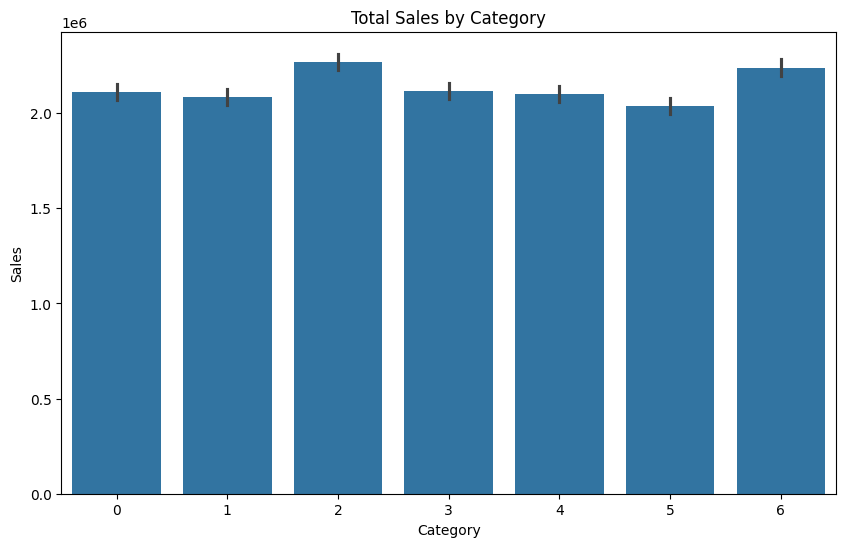

In [9]:
# %% ====================== SALES BY CATEGORY ======================

plt.figure(figsize=(10,6))
sns.barplot(x='Category', y='Sales', data=data, estimator=np.sum)
plt.title("Total Sales by Category")
plt.show()


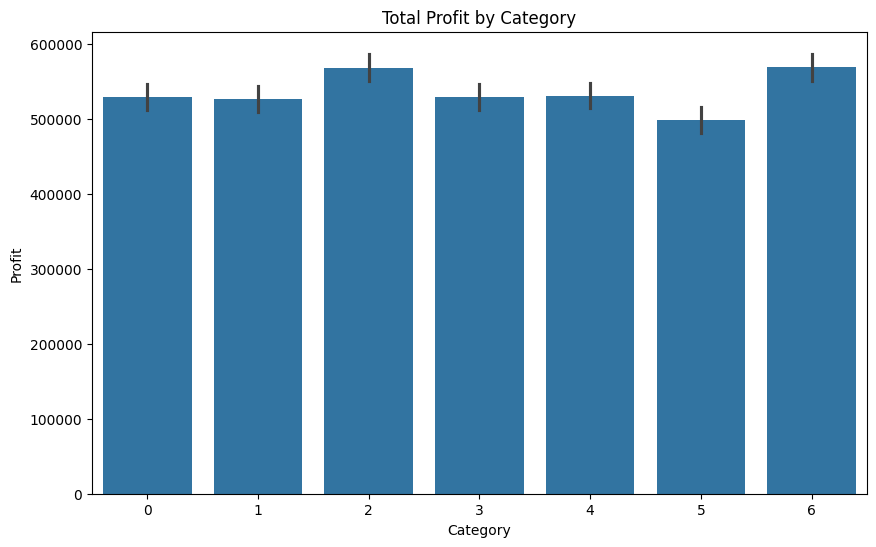

In [10]:
# %% ====================== PROFIT BY CATEGORY ======================

plt.figure(figsize=(10,6))
sns.barplot(x='Category', y='Profit', data=data, estimator=np.sum)
plt.title("Total Profit by Category")
plt.show()


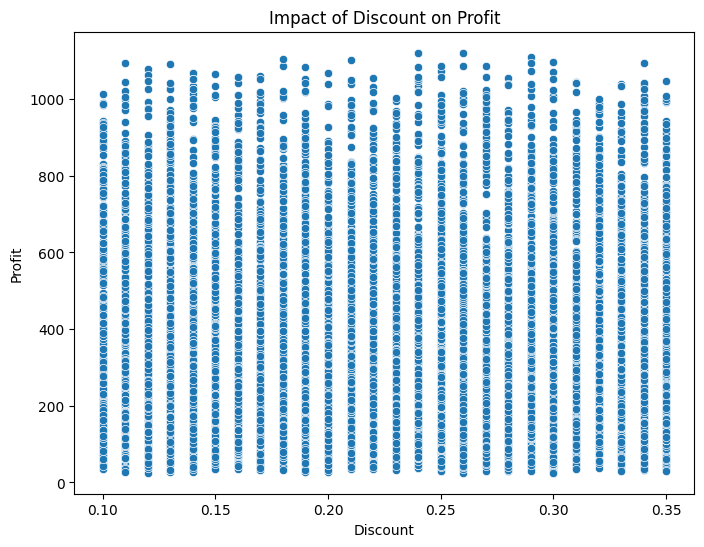

In [11]:
# %% ====================== DISCOUNT VS PROFIT ======================

plt.figure(figsize=(8,6))
sns.scatterplot(x='Discount', y='Profit', data=data)
plt.title("Impact of Discount on Profit")
plt.show()


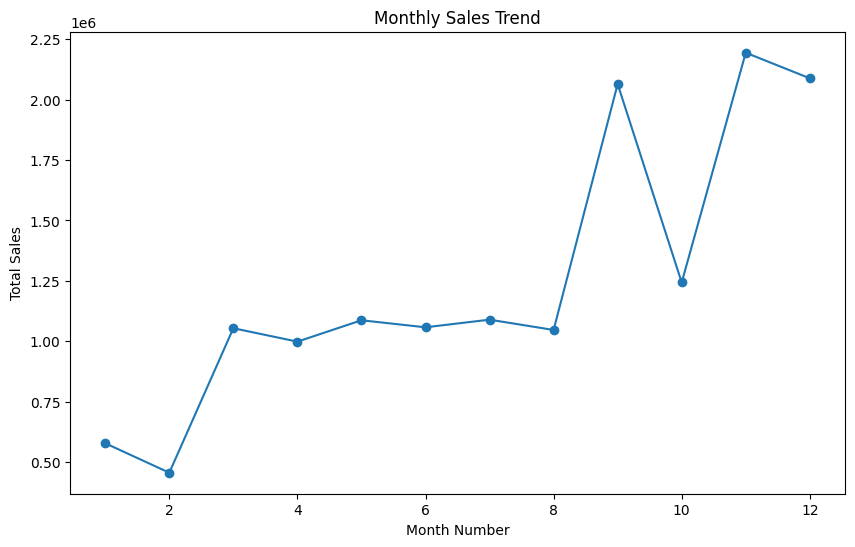

In [12]:
# %% ====================== MONTHLY SALES TREND ======================

monthly_sales = data.groupby('Order Month')['Sales'].sum().sort_index()

plt.figure(figsize=(10,6))
monthly_sales.plot(marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month Number")
plt.ylabel("Total Sales")
plt.show()


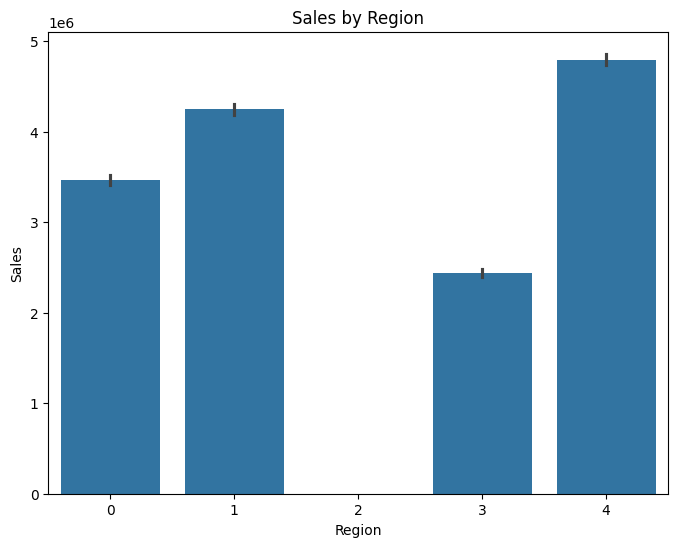

In [13]:
# %% ====================== REGION WISE SALES ======================

plt.figure(figsize=(8,6))
sns.barplot(x='Region', y='Sales', data=data, estimator=np.sum)
plt.title("Sales by Region")
plt.show()


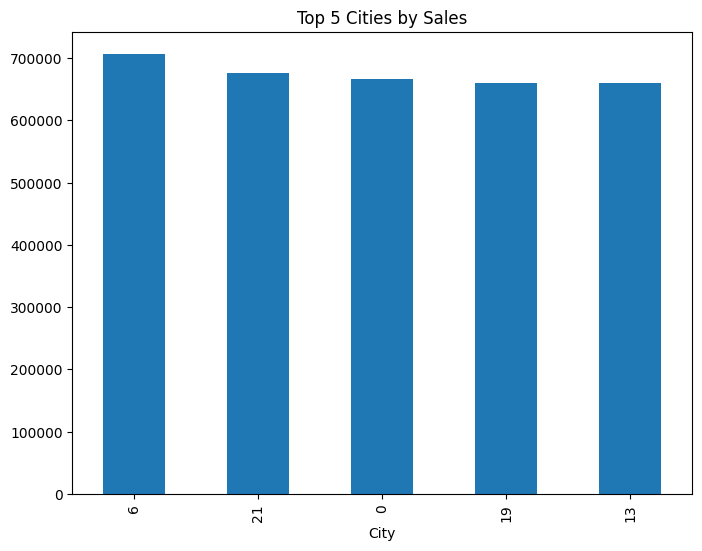

In [14]:
# %% ====================== TOP 5 CITIES ======================

top_cities = data.groupby('City')['Sales'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(8,6))
top_cities.plot(kind='bar')
plt.title("Top 5 Cities by Sales")
plt.show()


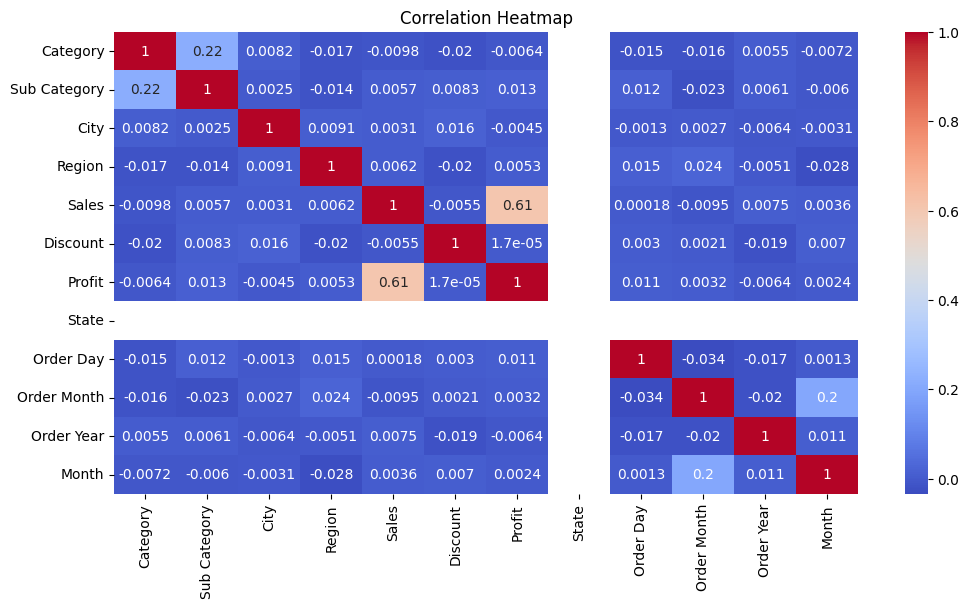

In [15]:
# %% ====================== CORRELATION HEATMAP ======================

plt.figure(figsize=(12,6))

numeric_data = data.select_dtypes(include=[np.number])  # Only numeric columns
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap")
plt.show()


In [16]:
# %% ====================== FEATURE SELECTION ======================

X = data.drop(columns=['Order ID', 'Customer Name', 'Order Date', 'Sales'])
y = data['Sales']


In [17]:
# %% ====================== TRAIN TEST SPLIT ======================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# %% ====================== FEATURE SCALING ======================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
# %% ====================== TRAIN LINEAR REGRESSION ======================

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [20]:
# %% ====================== MODEL EVALUATION ======================

# Linear Regression results
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_lr)
print("Root Mean Squared Error (RMSE):", rmse_lr)
print("R-squared:", r2_lr)
print("Average Sales Value:", y.mean())


Mean Squared Error: 212935.59126695254
Root Mean Squared Error (RMSE): 461.4494460576939
R-squared: 0.3543818382962983
Average Sales Value: 1496.5961576946167


In [21]:
# %% ====================== RANDOM FOREST MODEL ======================

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)


In [22]:
# %% ====================== GRADIENT BOOSTING MODEL ======================

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)


In [23]:
# %% ====================== MODEL COMPARISON ======================

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb],
    "R2 Score": [r2_lr, r2_rf, r2_gb]
})

results.sort_values(by="R2 Score", ascending=False)


,Model,RMSE,R2 Score
0,Linear Regression,461.449446,0.354382
2,Gradient Boosting,463.491764,0.348654
1,Random Forest,464.425173,0.346028


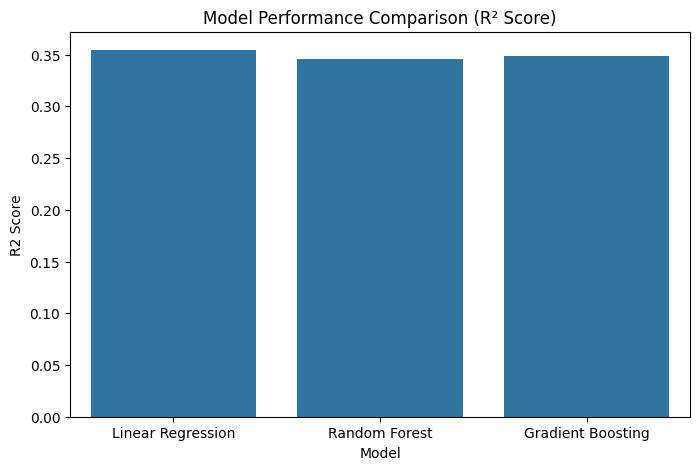

In [24]:
# %% ====================== MODEL PERFORMANCE VISUAL ======================

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="R2 Score", data=results)
plt.title("Model Performance Comparison (R² Score)")
plt.show()


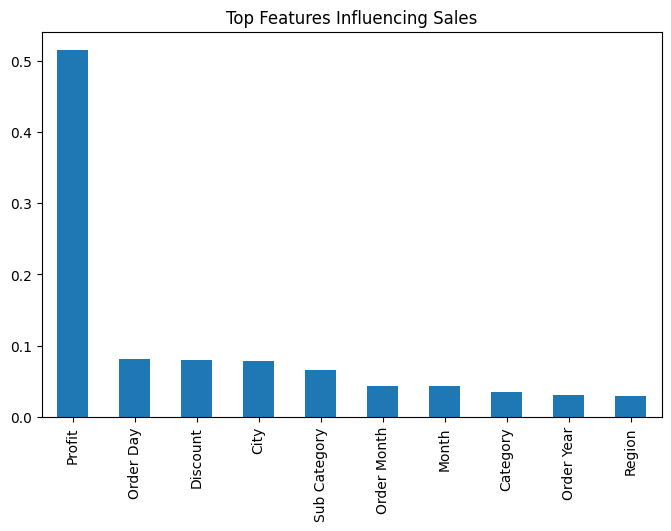

In [25]:
# %% ====================== FEATURE IMPORTANCE ======================

importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='bar')
plt.title("Top Features Influencing Sales")
plt.show()


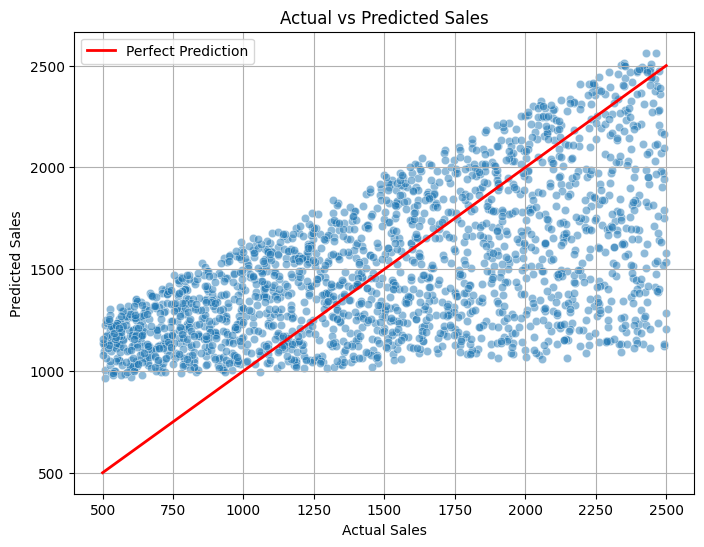

In [26]:
# %% ====================== FINAL ACTUAL VS PREDICTED (LINEAR REGRESSION) ======================

plt.figure(figsize=(8,6))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Prediction')

plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.grid(True)

plt.show()


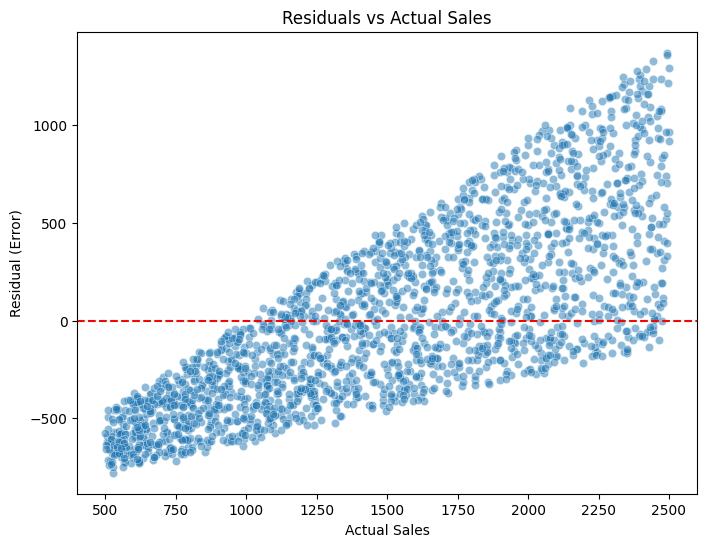

In [27]:
# %% ====================== RESIDUAL PLOT ======================

residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)

plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Residual (Error)")
plt.show()


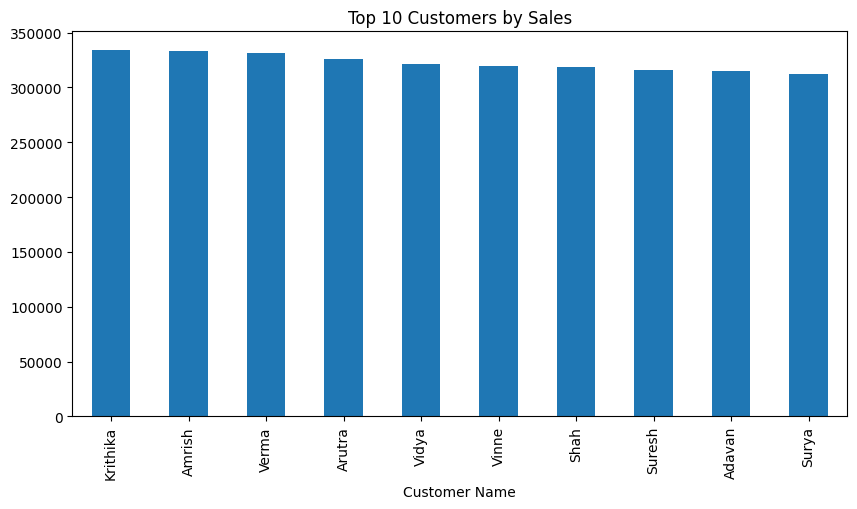

In [28]:
# %% ====================== TOP CUSTOMERS ======================

top_customers = data.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_customers.plot(kind='bar')
plt.title("Top 10 Customers by Sales")
plt.show()
